In [43]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.feature_selection import RFE
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import xgboost as xgb
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df=pd.read_csv('./playground-series-s5e3/train.csv')
test_df=pd.read_csv('./playground-series-s5e3/test.csv')

In [3]:
print("Train df shape:", train_df.shape)
print("Test df shape:", test_df.shape)

Train df shape: (2190, 13)
Test df shape: (730, 12)


In [4]:
train_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0


In [5]:
train_df.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
rainfall         0
dtype: int64

### Great! We do not have any missing values in the training dataset

In [6]:
test_df.head()

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,2190,1,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3
1,2191,2,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3
2,2192,3,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9
3,2193,4,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6
4,2194,5,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4


In [7]:
test_df.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    1
windspeed        0
dtype: int64

### Let's impute the missing value with the mean of that column

In [8]:
test_df['winddirection']=test_df['winddirection'].fillna(test_df['winddirection'].mean())

In [9]:
test_df.isna().sum()

id               0
day              0
pressure         0
maxtemp          0
temparature      0
mintemp          0
dewpoint         0
humidity         0
cloud            0
sunshine         0
winddirection    0
windspeed        0
dtype: int64

### Great! No missing values in the testing dataset

In [10]:
test_ids=test_df['id']

### Let's start working on training data now

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190 entries, 0 to 2189
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             2190 non-null   int64  
 1   day            2190 non-null   int64  
 2   pressure       2190 non-null   float64
 3   maxtemp        2190 non-null   float64
 4   temparature    2190 non-null   float64
 5   mintemp        2190 non-null   float64
 6   dewpoint       2190 non-null   float64
 7   humidity       2190 non-null   float64
 8   cloud          2190 non-null   float64
 9   sunshine       2190 non-null   float64
 10  winddirection  2190 non-null   float64
 11  windspeed      2190 non-null   float64
 12  rainfall       2190 non-null   int64  
dtypes: float64(10), int64(3)
memory usage: 222.6 KB


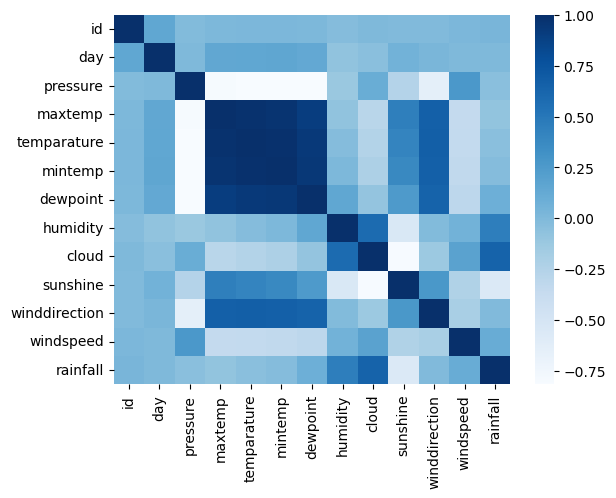

In [12]:
sns.heatmap(train_df.corr(), cmap="Blues")
plt.show()

In [13]:
features=[]
for i in train_df.columns:
    if(i=="id" or i=="rainfall" or i=="day"):
        continue
    else:
        features.append(i)

print(features)
print(len(features))

['pressure', 'maxtemp', 'temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'sunshine', 'winddirection', 'windspeed']
10


In [14]:
train_df.drop(columns=['id', 'day'], inplace=True)
test_df.drop(columns=['id', 'day'], inplace=True)

In [15]:
X=train_df.drop(columns=['rainfall'])
y=train_df['rainfall']

In [16]:
X.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8


In [17]:
scaler=MinMaxScaler()

X_scaled=scaler.fit_transform(X)

In [18]:
X_scaled=pd.DataFrame(X_scaled, columns=X.columns)

In [19]:
X_scaled.head()

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed
0,0.516854,0.421875,0.547718,0.616279,0.729630,0.813559,0.877551,0.090909,0.172414,0.232305
1,0.575843,0.226562,0.394191,0.457364,0.581481,0.949153,0.908163,0.000000,0.137931,0.317604
2,0.705056,0.351562,0.360996,0.410853,0.355556,0.610169,0.459184,0.685950,0.206897,0.248639
3,0.404494,0.300781,0.431535,0.500000,0.633333,0.949153,0.948980,0.000000,0.172414,0.566243
4,0.640449,0.425781,0.456432,0.434109,0.366667,0.220339,0.438776,0.297521,0.103448,0.370236


In [20]:
test_df_scaled=scaler.transform(test_df)

In [21]:
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.2)

In [22]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (1752, 10)
X_test shape: (438, 10)
y_train shape: (1752,)
y_test shape: (438,)


In [23]:
log_model=LogisticRegression()

In [24]:
log_model.fit(X_train, y_train)

LogisticRegression()

In [25]:
log_model_pred=log_model.predict(X_test)

In [26]:
print(classification_report(y_test, log_model_pred))

              precision    recall  f1-score   support

           0       0.76      0.59      0.66       111
           1       0.87      0.94      0.90       327

    accuracy                           0.85       438
   macro avg       0.82      0.76      0.78       438
weighted avg       0.84      0.85      0.84       438



In [27]:
prediction1=log_model.predict(test_df_scaled)

In [28]:
submission1=pd.DataFrame({"id": test_ids, "rainfall": prediction1})
submission1.to_csv("submission1.csv", index=False)
print("submission1 file created")

submission1 file created


In [29]:
rf_model=RandomForestClassifier()

rf_model.fit(X_train, y_train)

RandomForestClassifier()

In [30]:
rf_model_pred=rf_model.predict(X_test)

In [31]:
print(classification_report(y_test, rf_model_pred))

              precision    recall  f1-score   support

           0       0.76      0.64      0.69       111
           1       0.88      0.93      0.91       327

    accuracy                           0.86       438
   macro avg       0.82      0.78      0.80       438
weighted avg       0.85      0.86      0.85       438



In [32]:
prediction2=rf_model.predict(test_df_scaled)

In [33]:
submission2=pd.DataFrame({"id": test_ids, "rainfall": prediction2})
submission2.to_csv("submission2.csv", index=False)
print("submission2 file created")

submission2 file created


In [34]:
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',  # For binary classification
    eval_metric='logloss',        # Logarithmic loss function for evaluation
    use_label_encoder=False       # Disable label encoder warning
)

In [35]:
xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [36]:
xgb_model_pred=xgb_model.predict(X_test)

In [37]:
print(classification_report(y_test, xgb_model_pred))

              precision    recall  f1-score   support

           0       0.70      0.62      0.66       111
           1       0.88      0.91      0.89       327

    accuracy                           0.84       438
   macro avg       0.79      0.77      0.78       438
weighted avg       0.83      0.84      0.83       438



In [38]:
prediction3=xgb_model.predict(test_df_scaled)

In [39]:
submission3=pd.DataFrame({"id": test_ids, "rainfall": prediction3})
submission3.to_csv("submission3.csv", index=False)
print("submission3 file created")

submission3 file created


In [42]:
X_scaled.shape

(2190, 10)

### Let's build a Neural Network and find out how we doing in predicting the rainfall

In [44]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(10,)),  # Input layer (10 features)
    Dense(16, activation='relu'),  # Hidden layer
    Dropout(0.2),  # Dropout for regularization
    Dense(8, activation='relu'),  # Another hidden layer
    Dense(1, activation='sigmoid')  # Output layer (binary classification)
])

In [45]:
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352       
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 1)                 9         
                                                                 
Total params: 1025 (4.00 KB)
Trainable params: 1025 (4.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [46]:
history = model.fit(X_train, y_train, 
                    epochs=50, 
                    batch_size=32, 
                    validation_data=(X_test, y_test), 
                    verbose=1)

Epoch 1/50
55/55 [==============================] - 0s 2ms/step - loss: 0.6290 - accuracy: 0.7197 - val_loss: 0.5483 - val_accuracy: 0.7466
Epoch 2/50
55/55 [==============================] - 0s 530us/step - loss: 0.5068 - accuracy: 0.7551 - val_loss: 0.4824 - val_accuracy: 0.7466
Epoch 3/50
55/55 [==============================] - 0s 466us/step - loss: 0.4447 - accuracy: 0.7825 - val_loss: 0.4181 - val_accuracy: 0.8288
Epoch 4/50
55/55 [==============================] - 0s 788us/step - loss: 0.3990 - accuracy: 0.8333 - val_loss: 0.3957 - val_accuracy: 0.8333
Epoch 5/50
55/55 [==============================] - 0s 602us/step - loss: 0.3785 - accuracy: 0.8470 - val_loss: 0.3856 - val_accuracy: 0.8425
Epoch 6/50
55/55 [==============================] - 0s 595us/step - loss: 0.3631 - accuracy: 0.8562 - val_loss: 0.3820 - val_accuracy: 0.8425
Epoch 7/50
55/55 [==============================] - 0s 556us/step - loss: 0.3555 - accuracy: 0.8619 - val_loss: 0.3818 - val_accuracy: 0.8516
Epoch 8/

In [47]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

14/14 [==============================] - 0s 515us/step - loss: 0.3831 - accuracy: 0.8402
Test Accuracy: 0.84


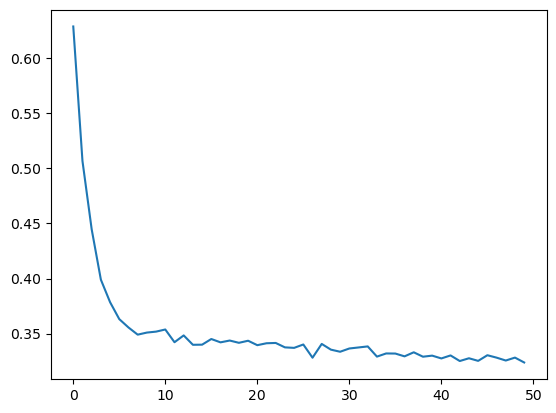

In [53]:
plt.plot(history.history['loss'])
plt.show()

In [68]:
prediction4=model.predict(test_df_scaled)

23/23 [==============================] - 0s 407us/step


In [69]:
prediction4=(prediction4>0.5).astype(int)

In [70]:
prediction4=prediction4.ravel()

In [71]:
submission4=pd.DataFrame({"id": test_ids, "rainfall": prediction4})
submission4.to_csv("submission4.csv", index=False)
print("submission4 file created")

submission4 file created


### Great! Got the Private Score: 0.76045 and Public: 0.75945